这次尝试的是随机森林，上次是梯度提升，这两个都属于基于树的模型。在神经网络之前都是很好去处理表格数据的模型。

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.head(3)
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)
dataset_df.info()

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0
Full train dataset shape is (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  Ove

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_19/3430012634.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


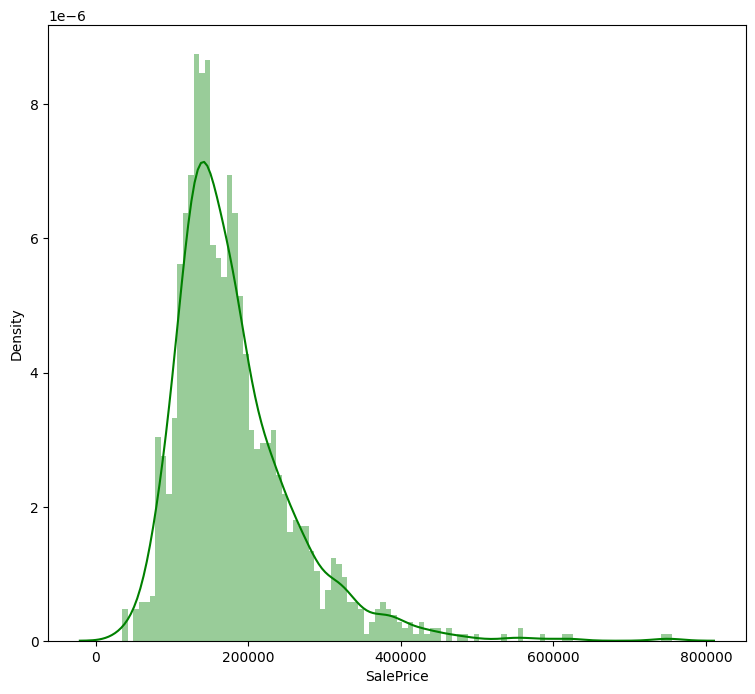

In [2]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

上面我们开始取 SalePrice 数据作为去预测的，去掉东西。

 我来先看看原本的数据，有一个大概的理解。看了 /train.csv
 OK，结合代码看懂了这个图和过程，就是把数据看个出来，直接看saleprice的情况，大概如图的数据分布。
 然后继续做什么事情

堆完数据看看数据，观察一下数据的情况，进而继续开发

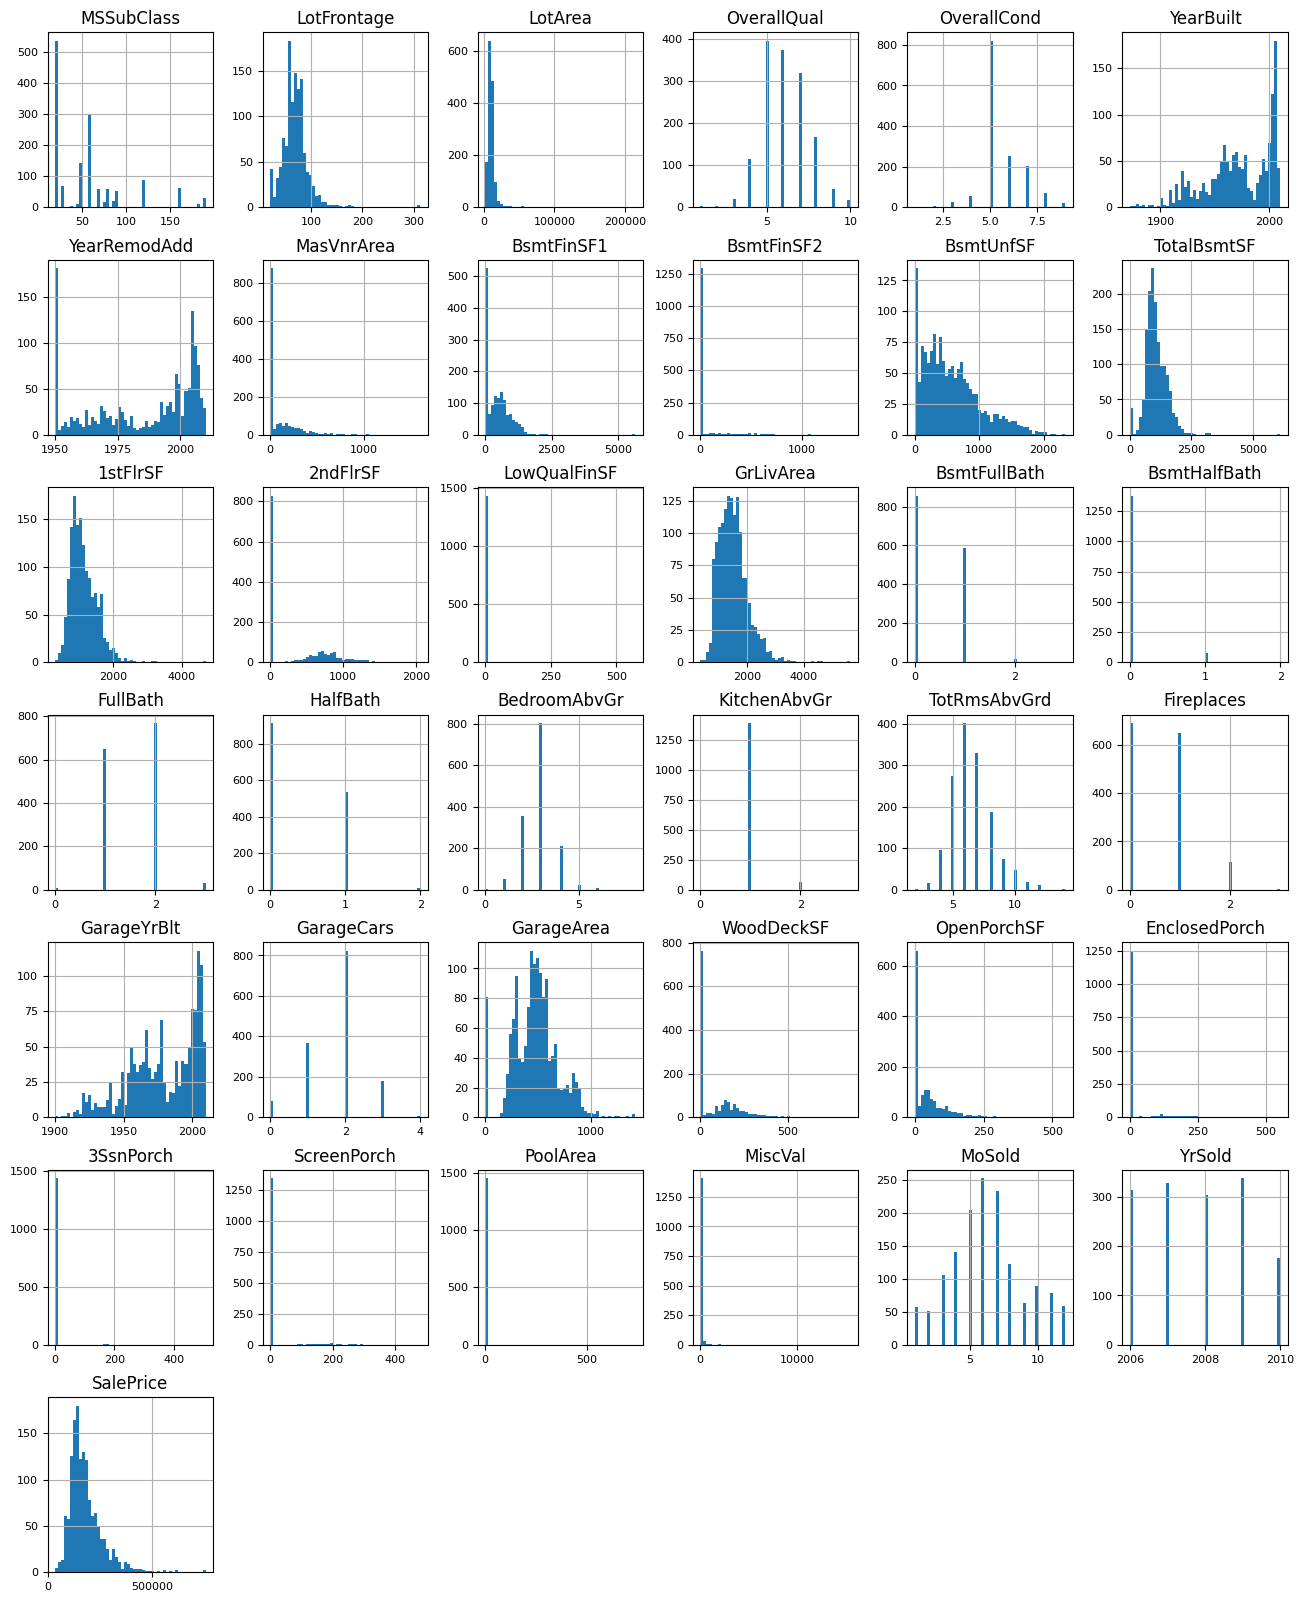

In [3]:
list(set(dataset_df.dtypes.tolist()))
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

现在结合要研究的整个数据集去看，从数据集的情况来判断和分析，这都是个人的思考过程和感受。不是什么固定的模式。
看完上面这些图后，我会明显地想到，这和我们的saleprice的图，那个比较相似的，就比较有相关性的结论。
比如一些明显的正比，也有明显的反比的。

以下的这个时候才开始进入model time。

将数据集分一下，为训练数据集 和 测试数据集

In [4]:
import numpy as np 

def split_dataset(dataset, test_ratio=0.30):
    # 这里是将数组中的元素直接裁取出来，一部分做训练数据，一部分做测试数据的
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]
# 上面的这种写法相当于js的filter，他是在numpy下的功能

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(len(train_ds_pd), len (valid_ds_pd)))

996 examples in training, 464 examples in testing.



以上的裁取，训练和测试的数据是不可以重叠一样，不然就是一个过渡拟合的过程，没有差异化，进而失去调整参数的过程了。

陈年老话，pd.dataframe 转 dataset for tf

In [5]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

选定它为关于回归问题的处理，是任务类型

In [6]:
tfdf.keras.get_all_models() # 跑这个先看看。

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

看到了四种，随机森林， 梯度提升，马车，购物车？，分布式的梯度增强


然后下面关于，配置这个模型的运转。

它有很好的默认设置，也有模版，可以直接选择模版，或者搞参数。

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel

这里有详情可以探究。

In [7]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpbvxknqth as temporary training directory


metrics=["mse"] 指定了“均方误差”（Mean Squared Error）作为模型的评估指标。均方误差是回归任务中常用的性能度量，它计算的是预测值与真实值之间差的平方的平均值。在机器学习模型的训练过程中，评价指标用于在验证数据上评估模型的性能，但不会影响模型的训练（即不会影响模型的损失函数）。 

In [8]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:08.454794. Found 996 examples.
Training model...


[INFO 23-12-11 10:00:56.5462 UTC kernel.cc:1243] Loading model from path /tmp/tmpbvxknqth/model/ with prefix ebc353edf2844c89


Model trained in 0:00:02.133999
Compiling model...


[INFO 23-12-11 10:00:56.9867 UTC decision_forest.cc:660] Model loaded with 300 root(s), 94528 node(s), and 75 input feature(s).
[INFO 23-12-11 10:00:56.9868 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-12-11 10:00:56.9868 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


可视化，下面的是，就爽了

In [9]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)


然后OOB的理解，我花了一些时间去理解。

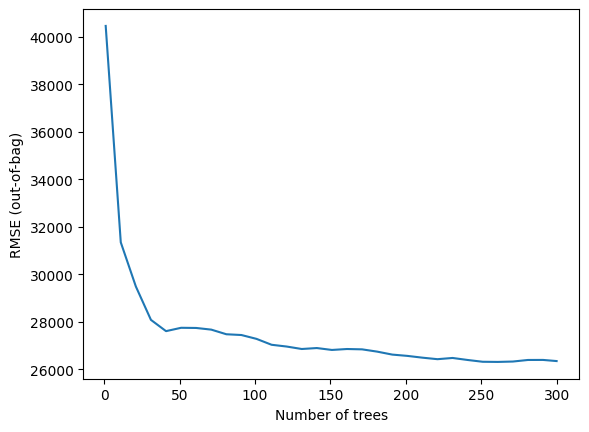

In [10]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [11]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=996, accuracy=None, loss=None, rmse=26343.412807992907, ndcg=None, aucs=None, auuc=None, qini=None)

In [12]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 819ms/step - loss: 0.0000e+00 - mse: 1112199424.0000
loss: 0.0000
mse: 1112199424.0000


这个均方误差这么大，模型跑的方式和数据集之间的交互关系还非常不好。 所以要找切入点和调整参数。

In [13]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE


In [14]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 104.0),
 ("GarageCars" (1; #32), 49.0),
 ("ExterQual" (4; #22), 44.0),
 ("Neighborhood" (4; #59), 32.0),
 ("GrLivArea" (1; #38), 24.0),
 ("GarageArea" (1; #31), 11.0),
 ("KitchenQual" (4; #44), 10.0),
 ("TotalBsmtSF" (1; #73), 8.0),
 ("YearBuilt" (1; #76), 8.0),
 ("BsmtQual" (4; #14), 6.0),
 ("1stFlrSF" (1; #0), 2.0),
 ("FullBath" (1; #29), 1.0),
 ("GarageYrBlt" (1; #37), 1.0)]

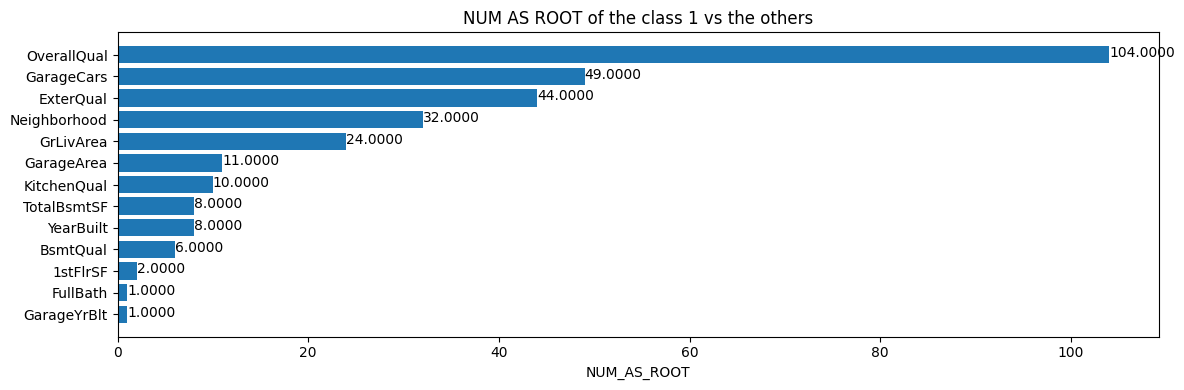

In [15]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [16]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 23ms/step


,Id,SalePrice
0,1461,125486.421875
1,1462,156702.671875
2,1463,184418.984375
3,1464,184981.218750
4,1465,195519.796875


In [17]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 27ms/step


,Id,SalePrice
0,1461,125486.421875
1,1462,156702.671875
2,1463,184418.984375
3,1464,184981.218750
4,1465,195519.796875
